In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
# from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub
from graphenetools import gt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

### If you import data from csv, put 1 here
is_csv = 1

#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/T1comm_data.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))
    dbase['boxdims'] = dbase['boxdims'].apply(lambda x: [float(t) for t in x.strip('[').strip(']').split(',')])

else:
### from raw data
    path = '/home/sang/UVM/He4T1set/OUTPUT'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
# Export data
# dbase.to_csv('../data/T1comm_data.csv',index=False)

In [4]:
def datadic_bysize(df):
    '''Make subset dataframes for each strain value and chemical potential'''
    sliced_dict = {}

    for N in df['totN'].unique():
        for T in df['T'].unique():
            subset = df[(df['totN'] == N)&(df['T'] == T)]
            if subset.empty:
                continue

            sliced_dict[str(N)+','+str(T)] = subset
    
    print(sliced_dict.keys())
    return sliced_dict

In [5]:
dfdict = datadic_bysize(dbase)

dict_keys(['90,1.0', '48,1.0', '64,1.0'])


In [6]:
def keysorting(k):
    t = k.split(',')
    n = float(t[0])*100000 + float(t[1])
    return n

keylst = []
for keys in dfdict.keys():
    keylst.append(keys)
keylst = sorted(keylst, key = lambda k: keysorting(k))
print(keylst)
print('number of category:', len(keylst))

['48,1.0', '64,1.0', '90,1.0']
number of category: 3


In [7]:
'''plot filling fraction and compressibilbity for single strain set'''
def simple_view(subset):
    if len(subset['strain'].unique()) != 1:
        print("the subset has more than one strain data")
        return None
    
    else:
        # sort by chemical potential
        subset = subset.sort_values('mu', ascending=True)
        subset = subset.reset_index()

        strain = round(subset['strain'].unique()[0] * 100)
        mulst = np.array(subset['mu'])
        nlst = np.array(subset['n'])
        nerrlst = np.array(subset['nerr'])
        totNlst = np.array(subset['totN'])
        fraclst = nlst/totNlst
        fracerrlst = nerrlst/totNlst
        kaplst = np.array(subset['kap'])
        
        # plot figure
        plt.style.reload_library()
        with plt.style.context(plot_style['sans']):
            p1 = plt.figure( figsize = [6,4])
            dgutils.fonts.set_custom_font(font_path)

            plt.ylim(0, 1)
            plt.xlim(-130,-30)

            fracp = plt.errorbar(mulst, fraclst, yerr = fracerrlst, label = 'fraction',
                                   fmt='-.', marker = '.', color = 'orange', ecolor='grey')
            mup = plt.bar(mulst, list(kaplst), label = 'compressibility')

            # Search 1/3 filling states
            for i in range(len(fraclst)):
                if fraclst[i] > 1/3-0.01 and fraclst[i] < 1/3+0.01 and kaplst[i] < 0.05:
                    print('1/3 low:', mulst[i])
                    break
            for i in range(len(fraclst)):
                if fraclst[-i-1] > 1/3-0.01 and fraclst[-i-1] < 1/3+0.01 and kaplst[-i-1] < 0.05:
                    print('1/3 high:', mulst[-i-1])
                    break

            # Search 7/16 filling states
            for i in range(len(fraclst)):
                if fraclst[i] > 7/16-0.01 and fraclst[i] < 7/16+0.01 and kaplst[i] < 0.05:
                    print('7/16 low:', mulst[i])
                    break
            for i in range(len(fraclst)):
                if fraclst[-i-1] > 7/16-0.01 and fraclst[-i-1] < 7/16+0.01 and kaplst[-i-1] < 0.05:
                    print('7/16 high:', mulst[-i-1])
                    break


            line1 = plt.axhline(1/3, c = 'tab:green' ,alpha = 0.5, label = '1/3')
            line2 = plt.axhline(7/16, c = 'tab:orange', alpha = 0.5, label = '7/16')
            line3 = plt.axhline(7/12, c = 'tab:red', alpha = 0.5, label = '7/12')
            line4 = plt.axhline(2/3, c = 'tab:purple', alpha = 0.5, label = '2/3')

            legend1 = plt.legend(handles = [line1,line2,line3,line4],
                                loc='upper center', bbox_to_anchor=(0.5, 1.00),
                                ncol=4, fancybox=True, shadow=True, fontsize = 14)
            legend2 = plt.legend([fracp, mup], ['filling fraction', 'compressibility'], loc=4, fontsize = 14)
            plt.gca().add_artist(legend1)
            plt.gca().add_artist(legend2)

            plt.title(f"strain {strain} %", fontsize = 18)
            plt.xlabel("chemical potential (K)", fontsize = 16)
            plt.ylabel("filling fraction", fontsize = 16)
            plt.xticks([-120,-100,-80,-60,-40], fontsize=14)
            plt.yticks([0.2,0.4,0.6,0.8 ],fontsize=14)
    #         plt.show()
        return p1

1/3 low: -123.0
1/3 high: -112.0
7/16 low: -102.0
7/16 high: -90.0


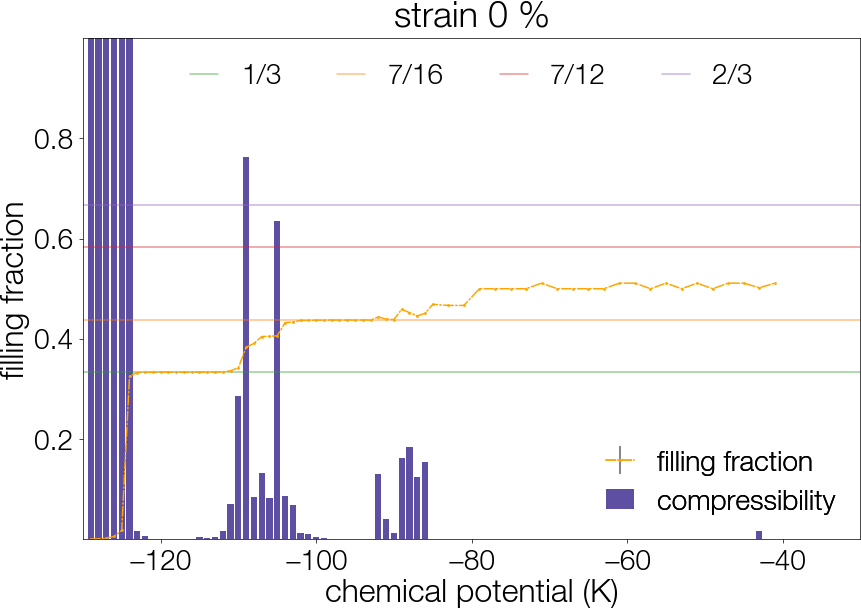

In [9]:
s = 0
subset = dbase[dbase['strain'] == s/100]
subset = subset.sort_values('mu', ascending=True)
subset = subset.reset_index()
p1 = simple_view(subset)
#p1.savefig(f'../figures/ff_at{s:02}.pdf')

1/3 low: -123.0
1/3 high: -112.0
7/16 low: -102.0
7/16 high: -90.0
1/3 low: -121.0
1/3 high: -111.0
7/16 low: -102.0
7/16 high: -91.0
1/3 low: -119.0
1/3 high: -111.0
7/16 low: -102.0
7/16 high: -91.0
1/3 low: -116.0
1/3 high: -110.0
7/16 low: -101.0
7/16 high: -93.0
1/3 low: -114.0
1/3 high: -110.0
7/16 low: -101.0
7/16 high: -96.0
1/3 low: -112.0
1/3 high: -108.0
7/16 low: -100.0
7/16 high: -97.0
1/3 low: -110.0
1/3 high: -108.0
7/16 low: -100.0
7/16 high: -96.0
1/3 low: -108.0
1/3 high: -107.0
7/16 low: -99.0
7/16 high: -97.0


<ipython-input-7-2adaf187f8f7>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  p1 = plt.figure( figsize = [6,4])


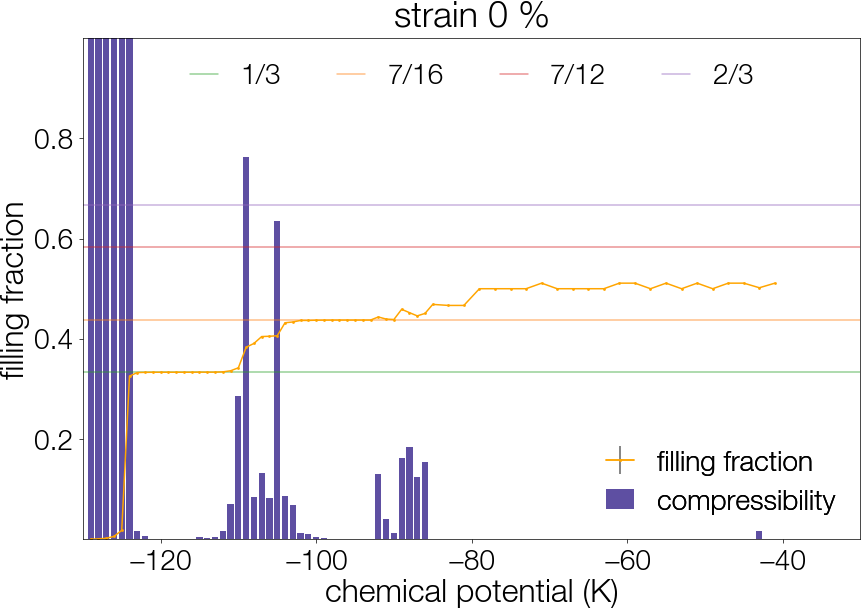

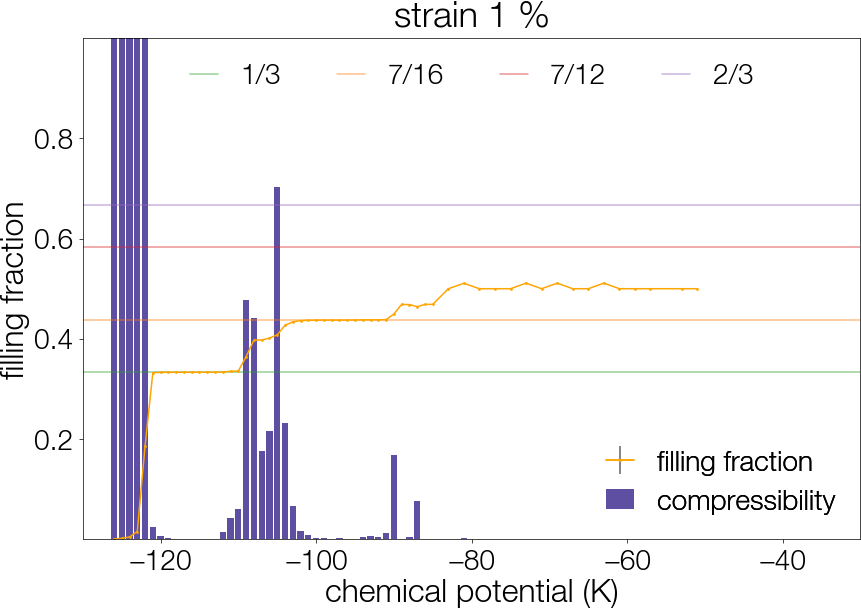

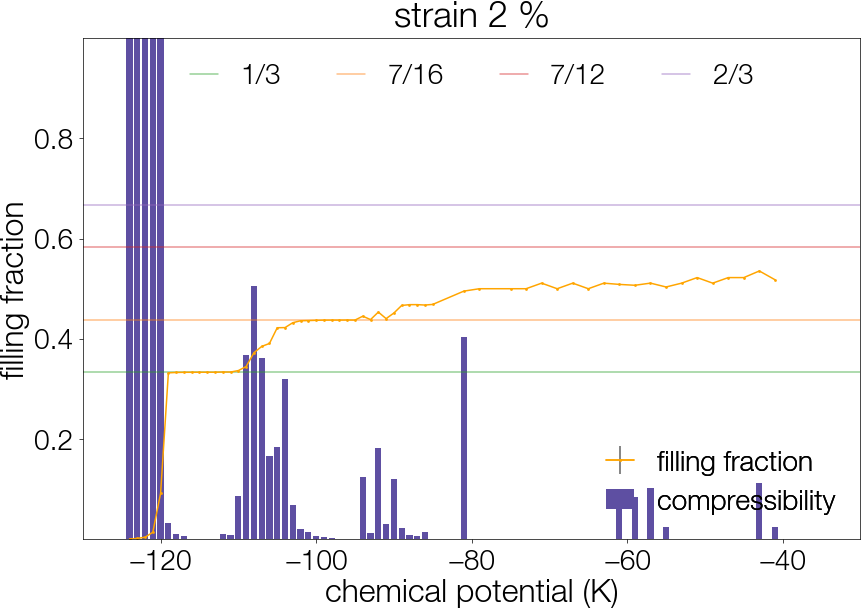

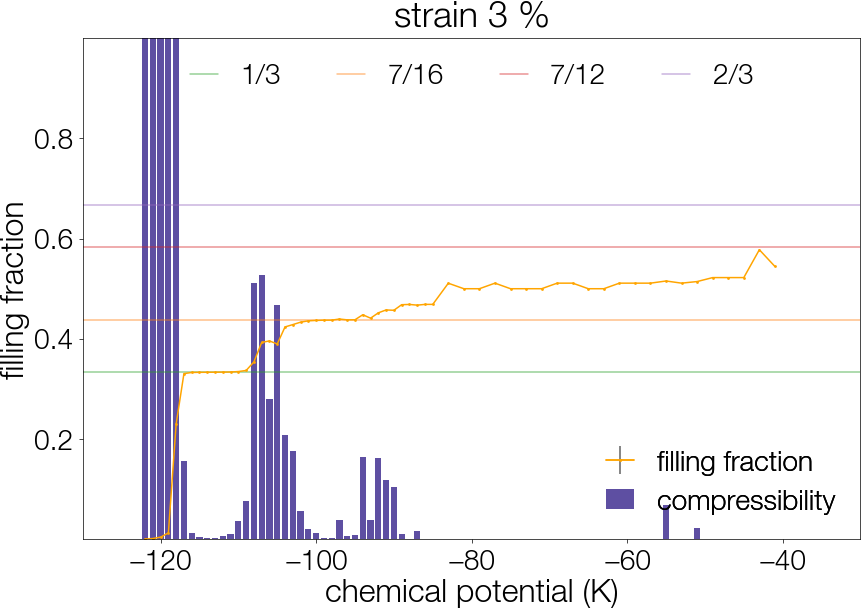

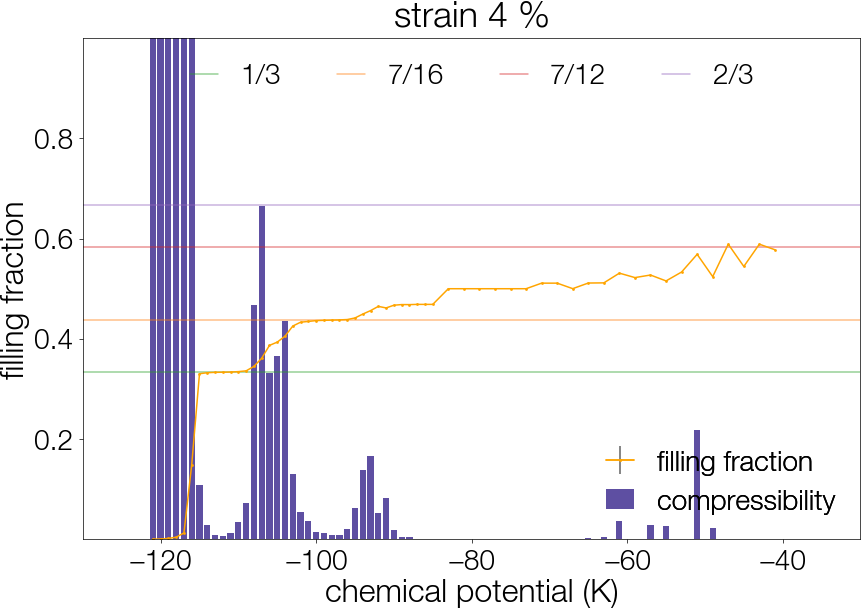

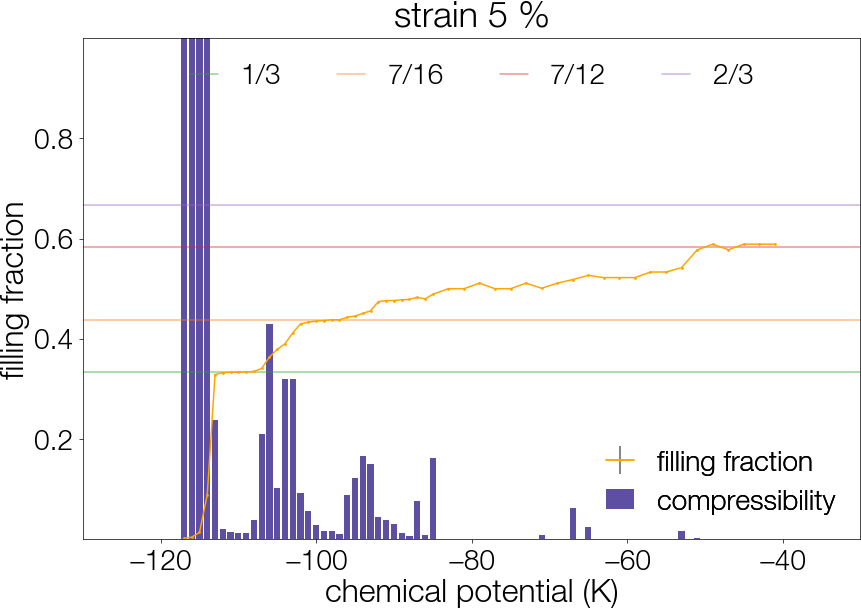

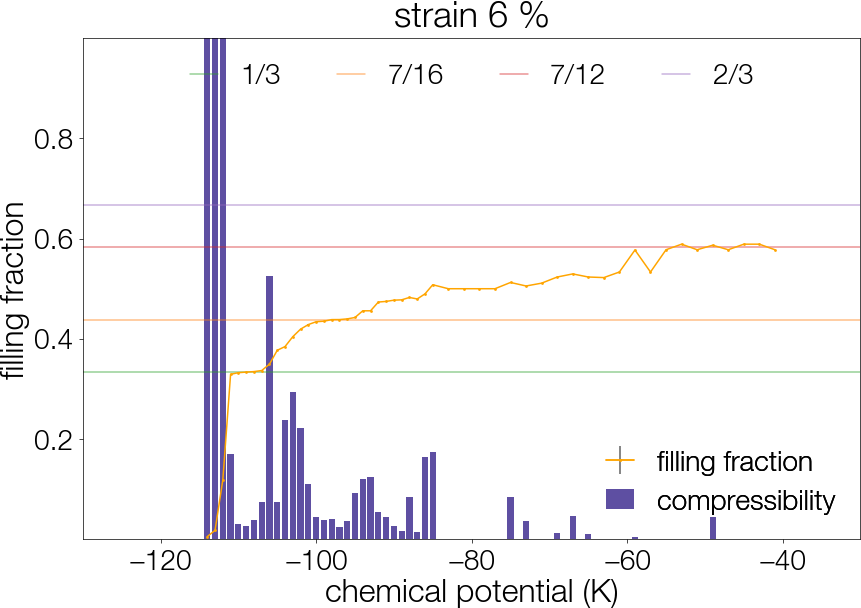

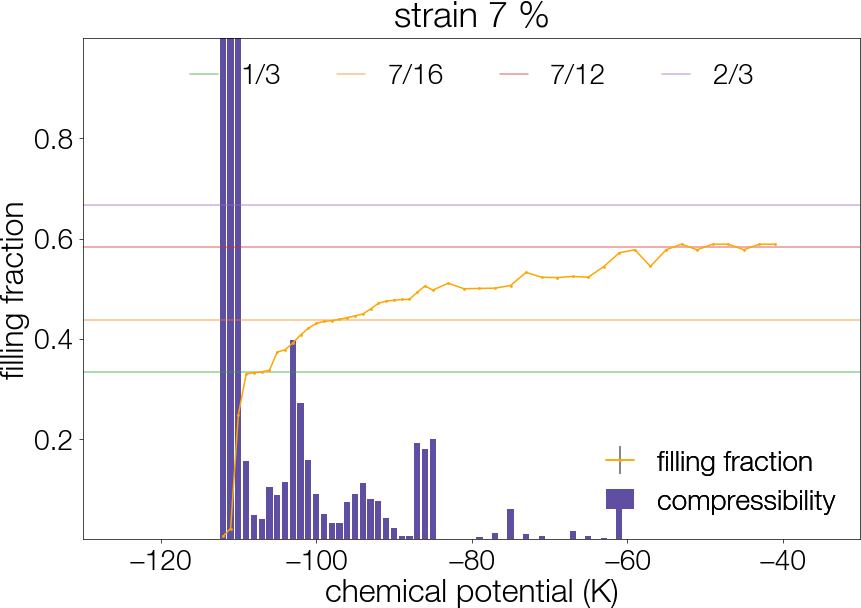

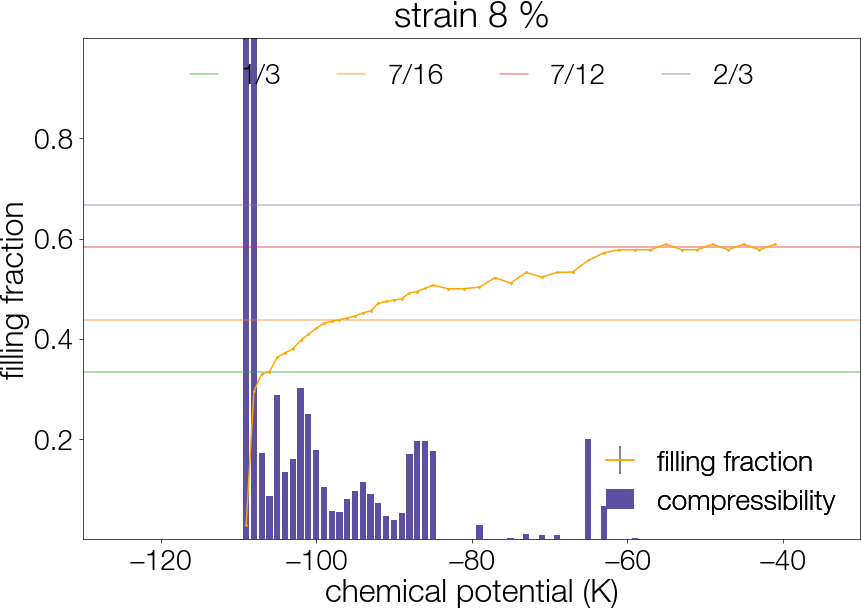

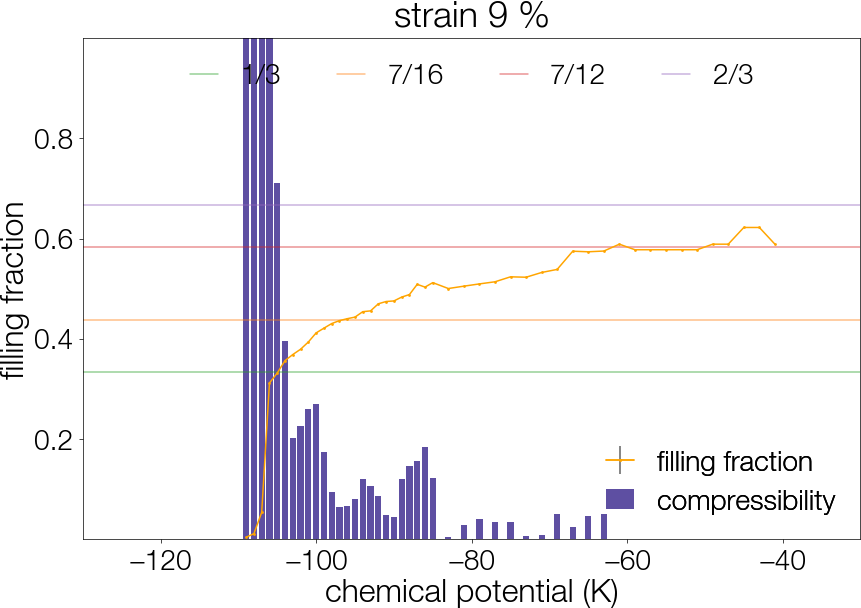

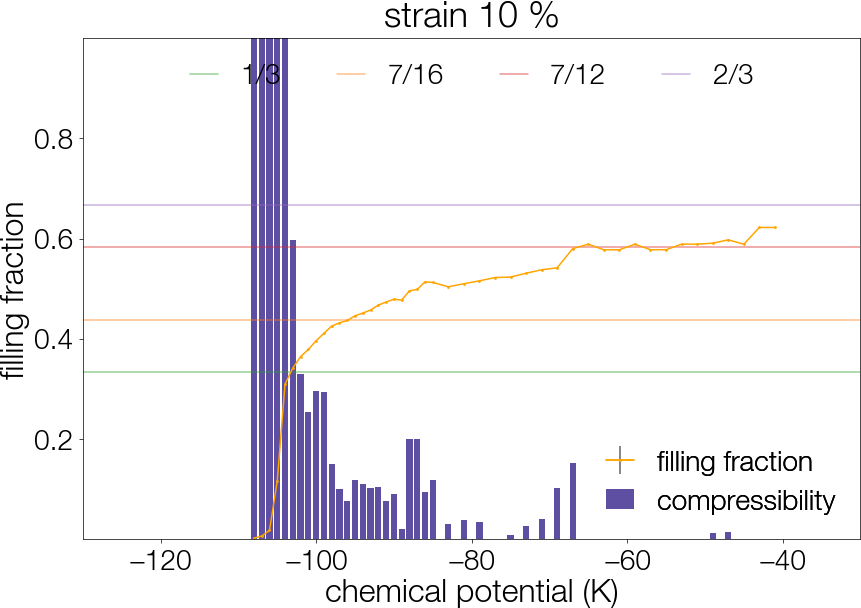

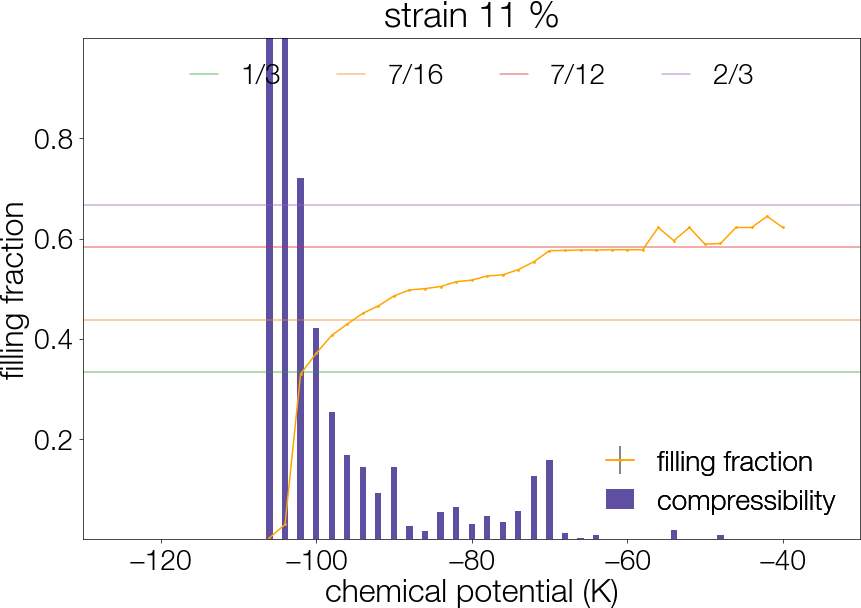

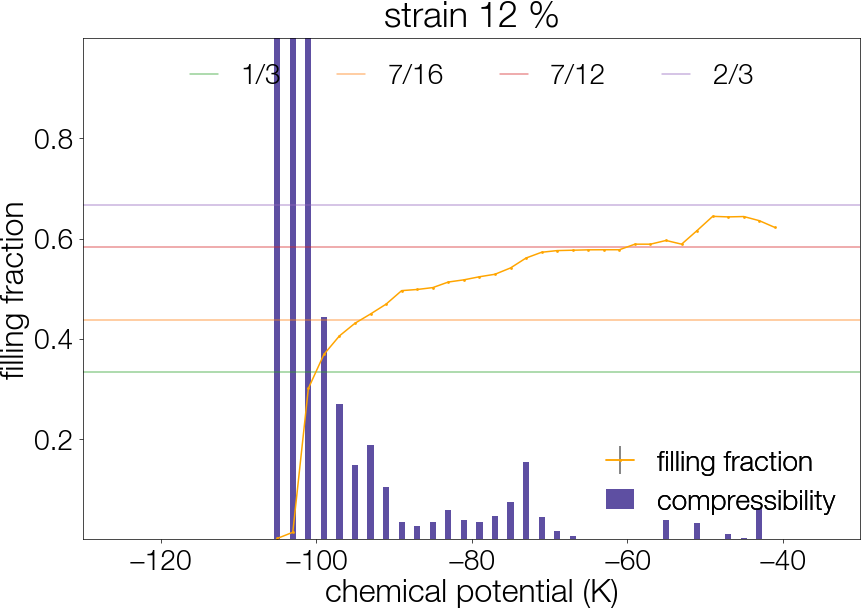

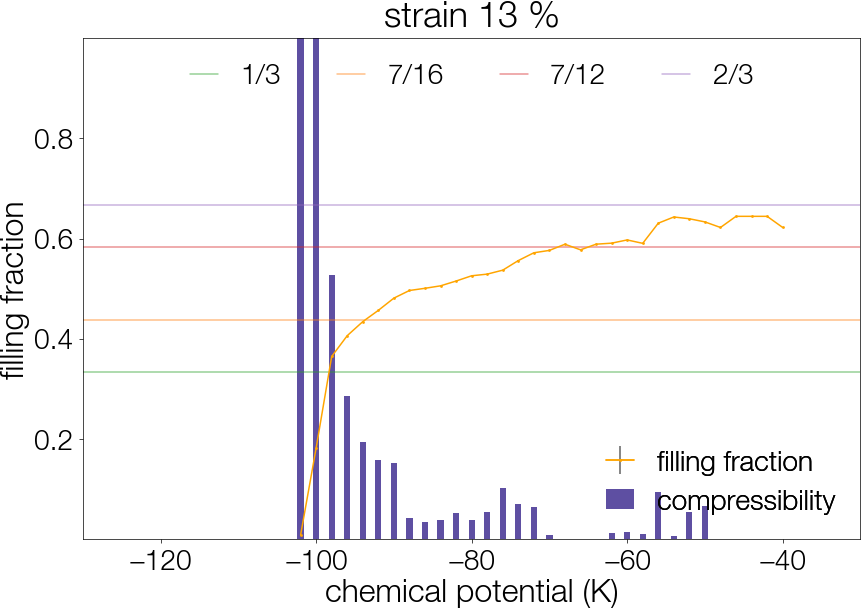

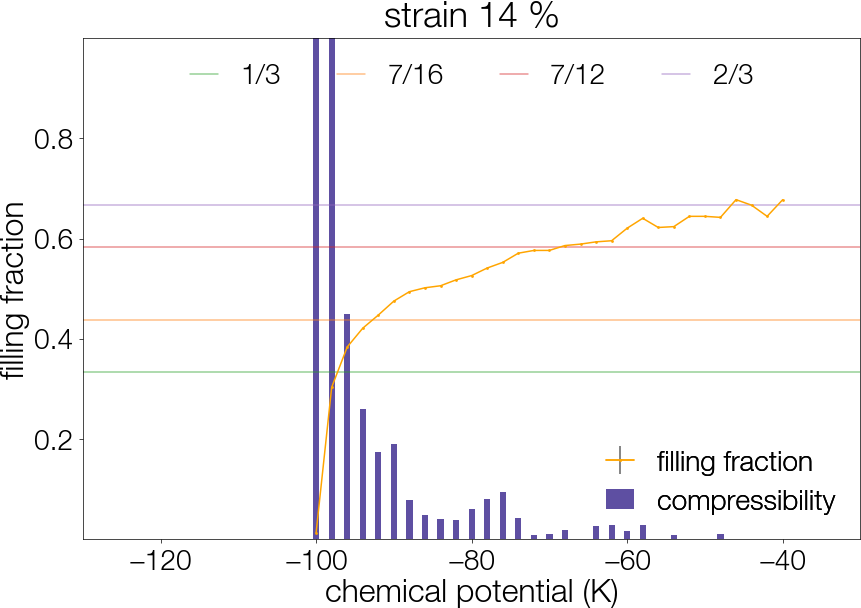

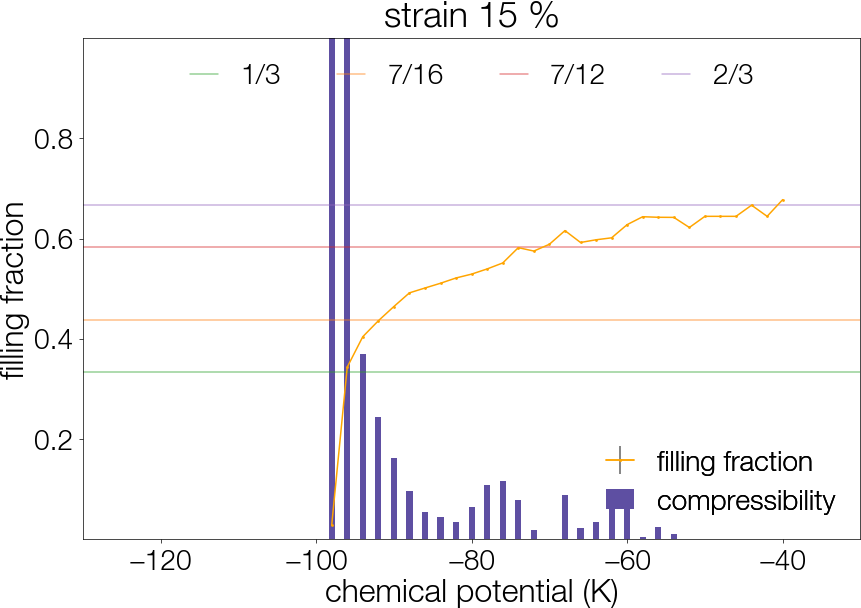

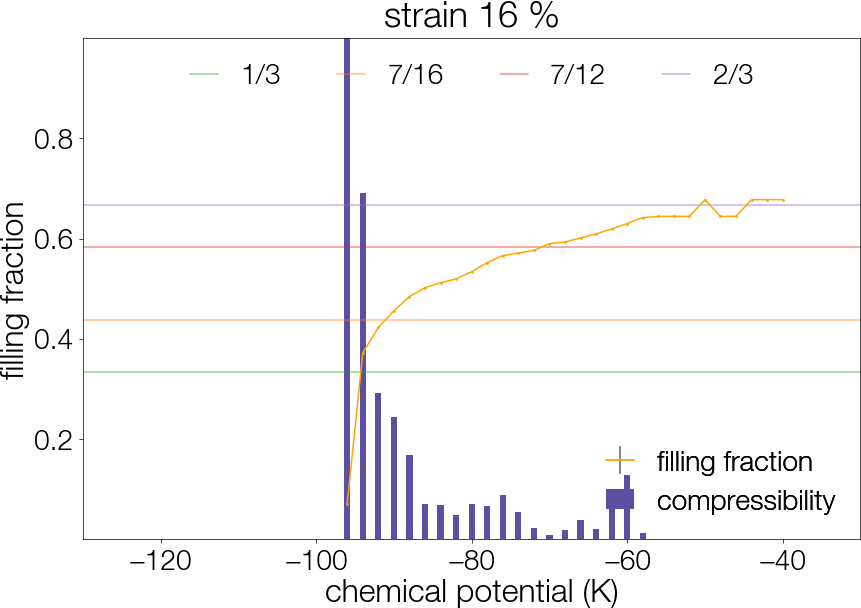

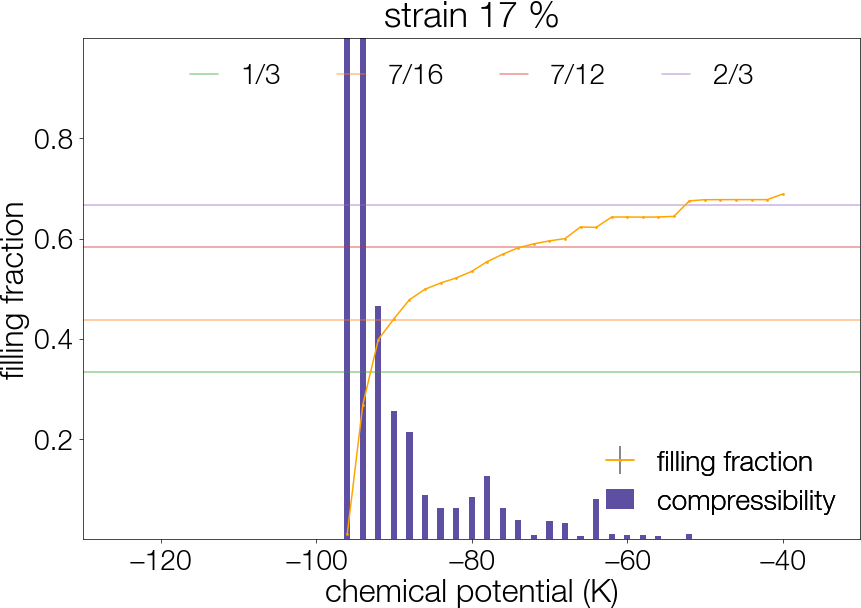

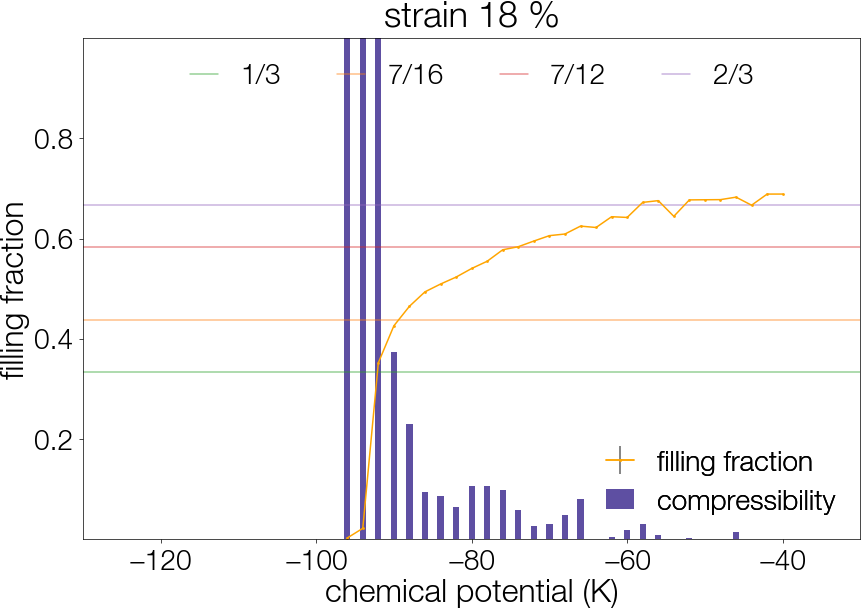

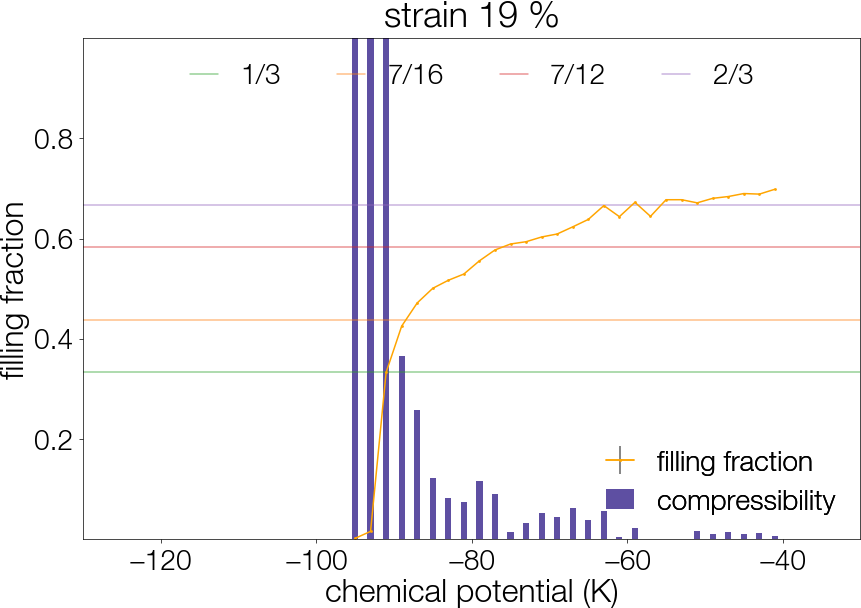

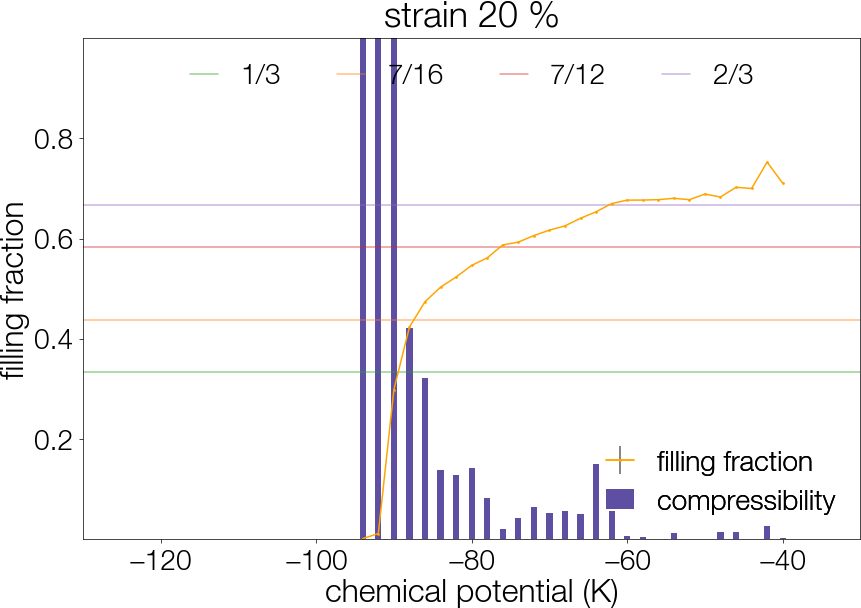

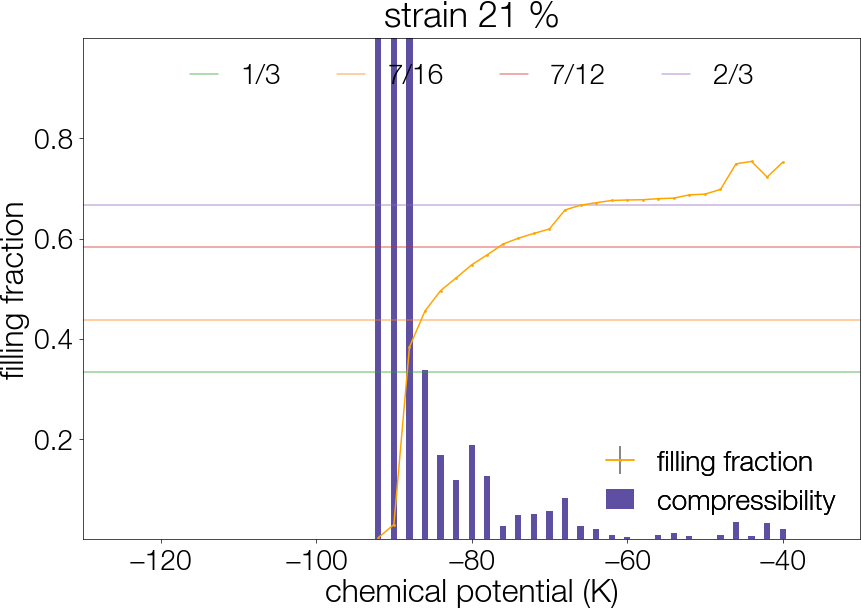

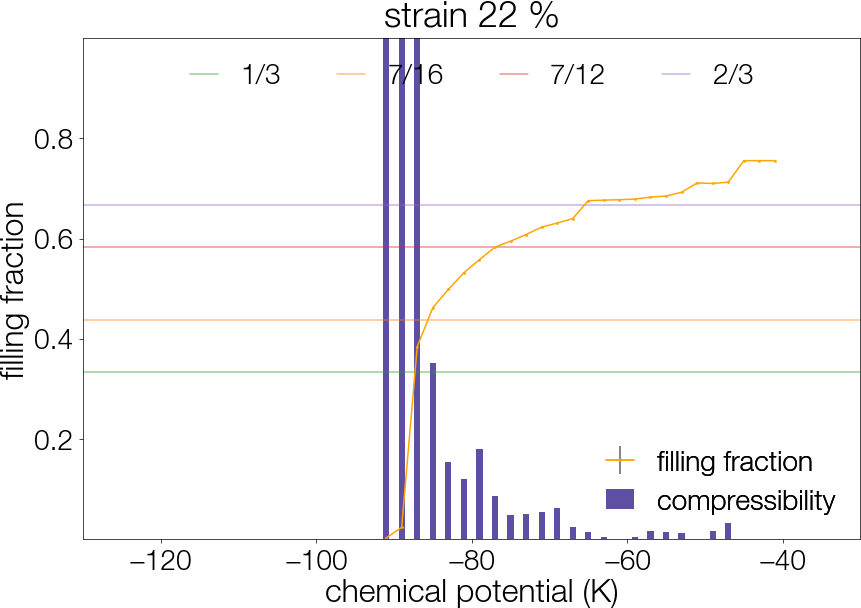

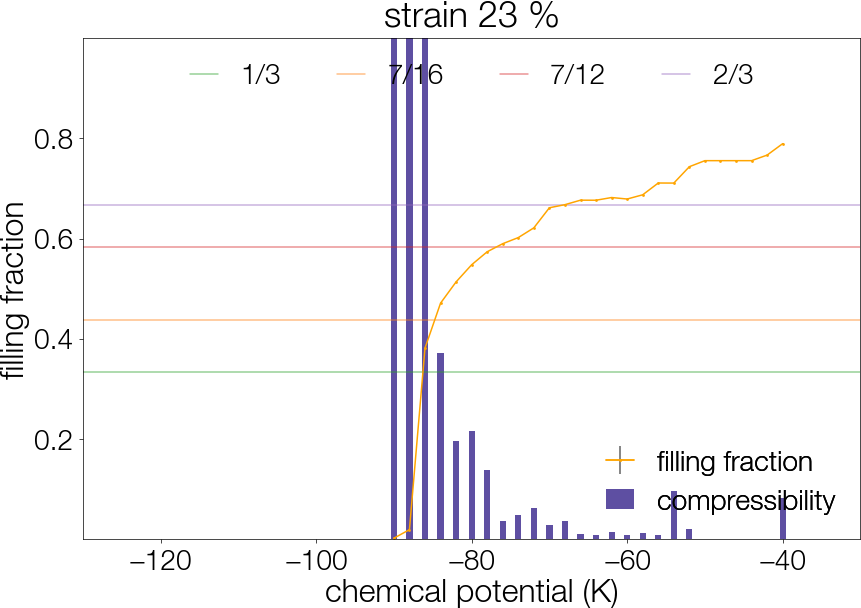

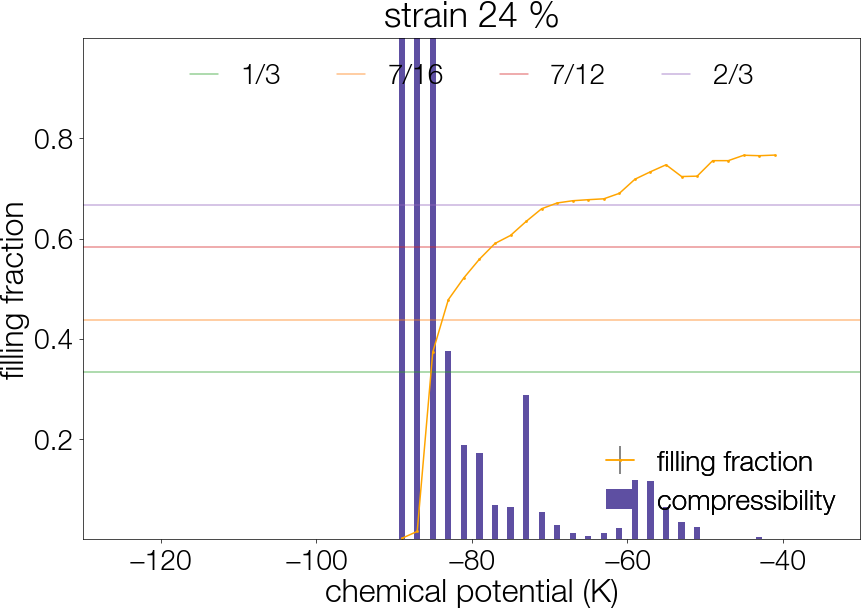

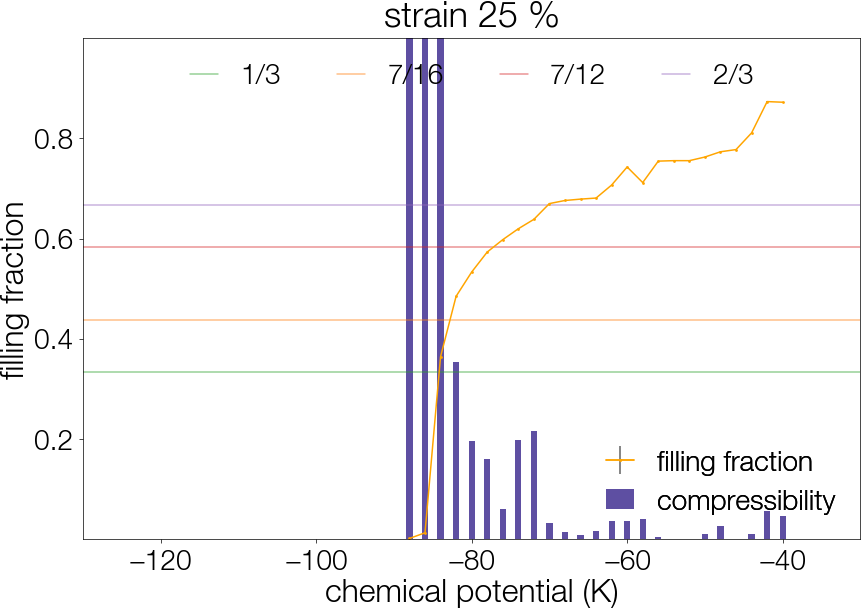

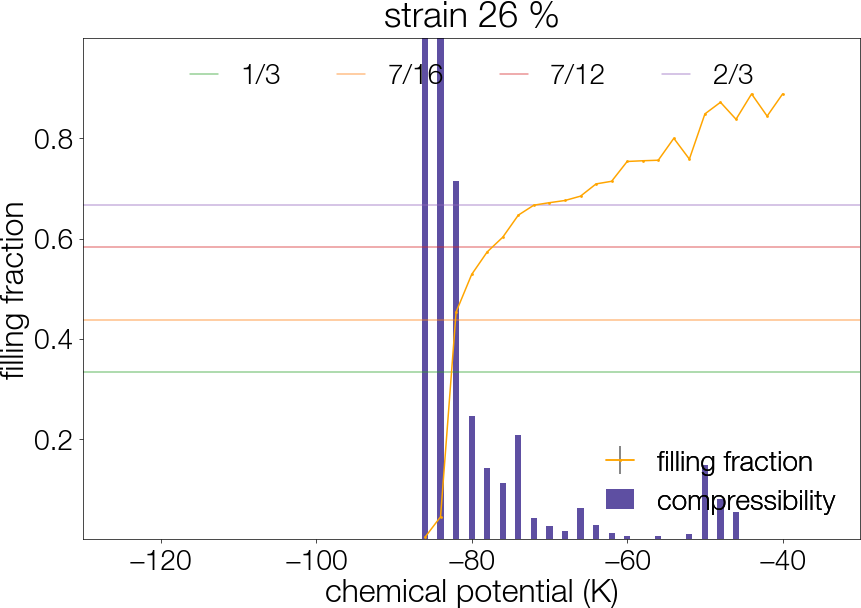

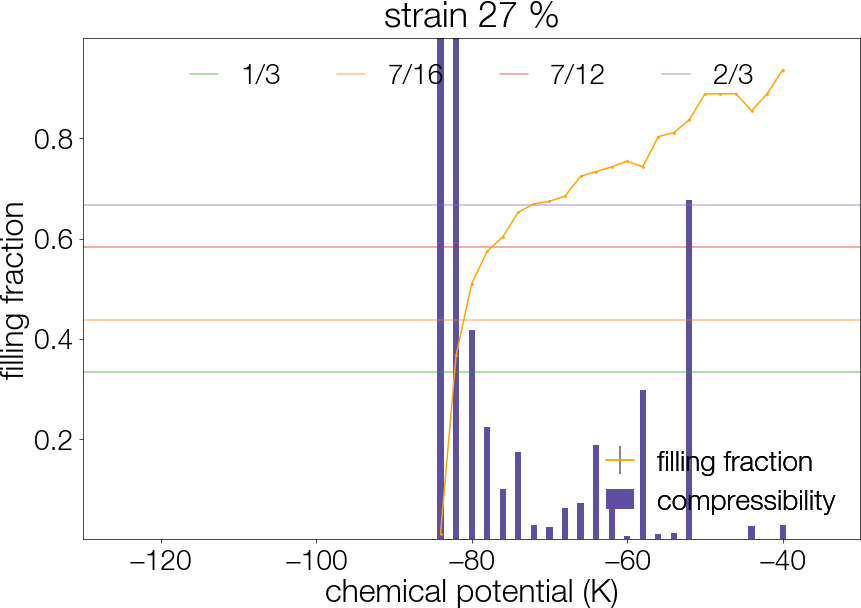

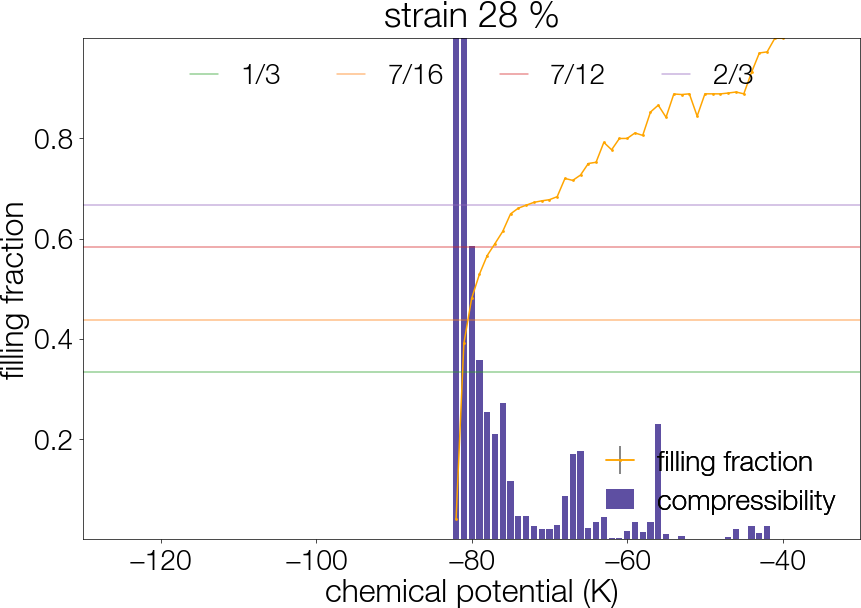

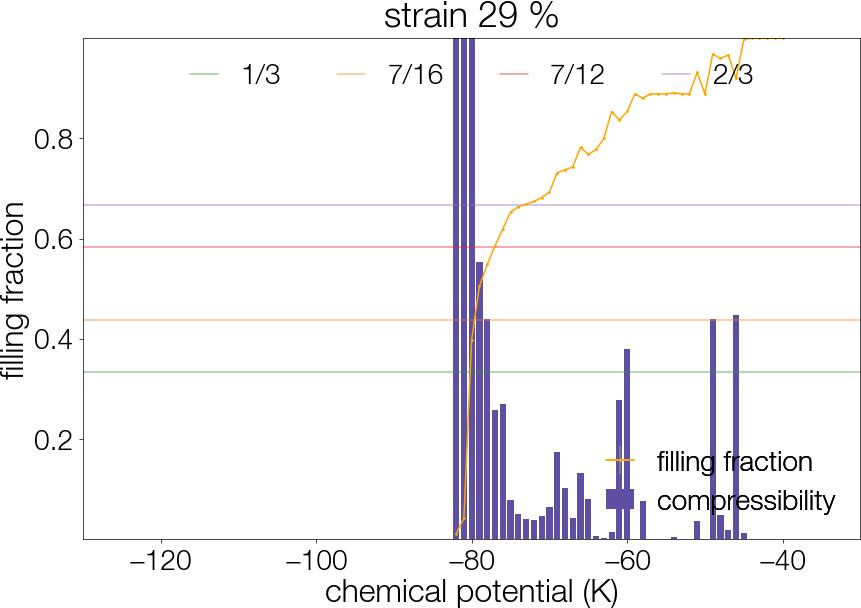

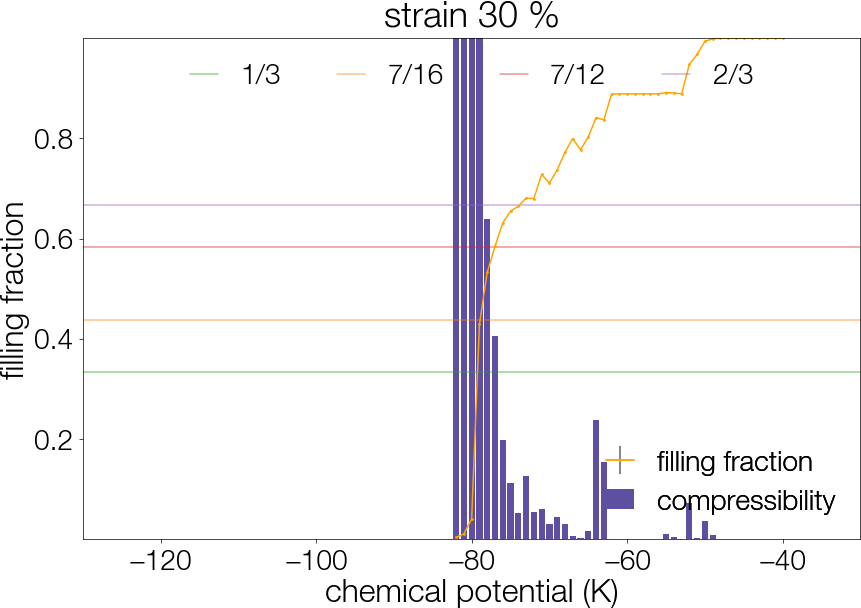

In [10]:
### Store all figures. 
# for s in range(31):
#     subset = dbase[dbase['strain'] == s/100]
#     subset = subset.sort_values('mu', ascending=True)
#     subset = subset.reset_index()
#     pic = simple_view(subset)
#     pic.savefig(f'../figures/phase_each/ff_at{s:02}')

In [8]:
# Record 1/3 filling phases
one_third_bound = [[-123.0,-112.0],
                   [-121.0,-111.0],
                   [-119.0,-111.0],
                   [-116.0,-110.0],
                   [-114.0,-110.0],
                   [-112.0,-108.0],
                   [-110.0,-108.0],
                  ]

In [9]:
# record 7/16 filling phases
seven_bound = [[-102.0,-90.0],
                [-102.0,-91.0],
                [-102.0,-91.0],
                [-101.0,-93.0],
                [-101.0,-96.0],
                [-100.0,-97.0],
                [-100.0,-96.0],
               [-99.0,-97.0],
                  ]

In [10]:
# return mu and 2d density rho
def den_maker(subset):
    if len(subset['strain'].unique()) != 1:
        print("the subset has more than one strain data")
        return None
    else:
        subset = subset.sort_values('mu', ascending=True)
        subset = subset.reset_index()

        mulst = np.array(subset['mu'])

        rho_lst = []

        for idx, row in subset.iterrows():
            file = row['filedic']['planeavedensity'] #file location
            with open(file,'r') as lines:
                header = lines.readline()
            ngridsep = int(header.split(' ')[-1][:-1])
            densityData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
            rho = densityData.reshape([ngridsep,ngridsep]) #reshape to 2d
            rho_lst.append(rho)
            
        return mulst, rho_lst

# Compressibility map

In [11]:
strain_lst = np.arange(0,31,1)

mu_lst = [list( dbase[dbase['strain'] == int(s)/100].sort_values('mu', ascending=True)['mu'] ) for s in strain_lst]

kap_lst = [list( dbase[dbase['strain'] == int(s)/100].sort_values('mu', ascending=True)['kap'] ) for s in strain_lst]

In [12]:
# cap 1 to kappa
for item in kap_lst:
    for i in range(len(item)):
        if item[i] > 1.0:
            item[i] = 1.0

In [13]:
# insert regulator value
for i in range(len(strain_lst)):
    mu_lst[i].insert(0, mu_lst[0][0]-1.0)
    kap_lst[i].insert(0, 1.0)

In [14]:
# fix error at 1%
mu_lst[1].append(mu_lst[0][-1])
kap_lst[1].append(kap_lst[1][-1])

In [15]:
# 2d array for kappa
from scipy.interpolate import interp1d

data_cprb_intp = np.ones((31,100))
murange = np.linspace(mu_lst[0][0],mu_lst[0][-1],100)
for i in range(len(strain_lst)):
    f_kapdata = interp1d(mu_lst[i], kap_lst[i])
    new_kapdata = f_kapdata(murange)
    for j in range(100):
        data_cprb_intp[i,j] = new_kapdata[j]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue


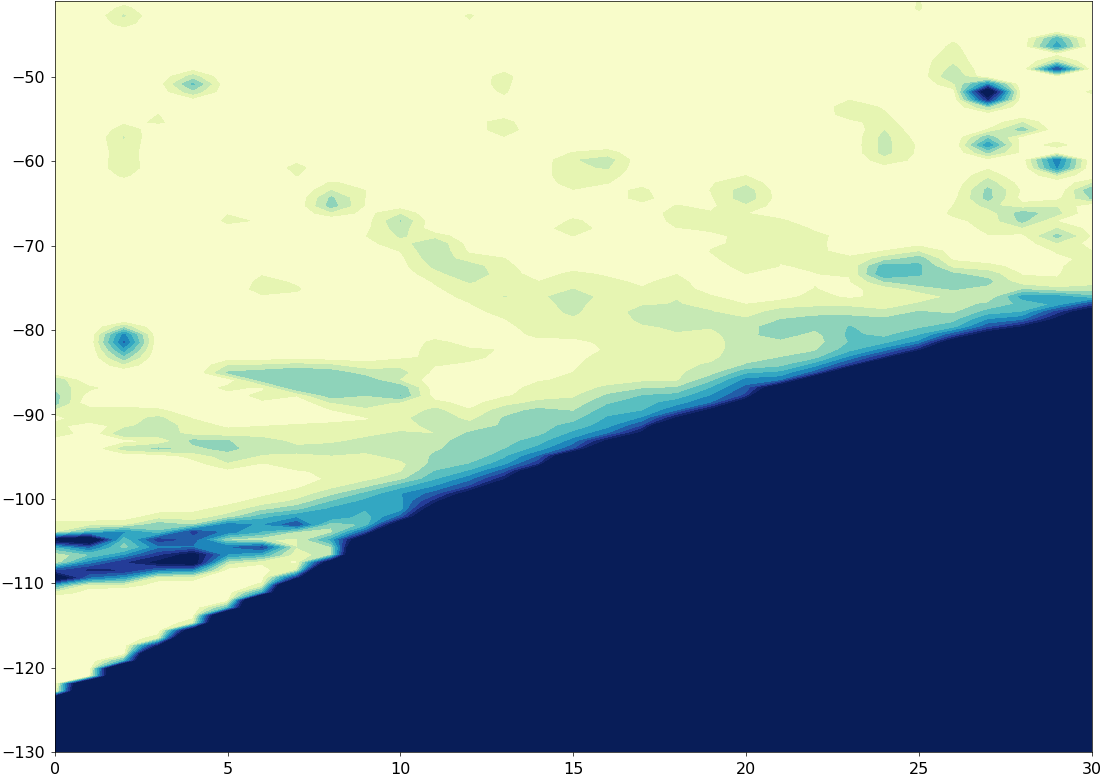

In [16]:
ppfig, ax = plt.subplots(figsize = [8,6])
pphase = ax.contourf(strain_lst, murange, np.transpose(data_cprb_intp),20, vmin = 0, vmax = 0.50, cmap="YlGnBu")

In [17]:
# import vacuum data
vac_line_x = np.genfromtxt("../data/vacuumline_x.csv")
vac_line_y1 = np.genfromtxt("../data/vacuumline_yd.csv")
vac_line_y2 = np.genfromtxt("../data/vacuumline_yu.csv")

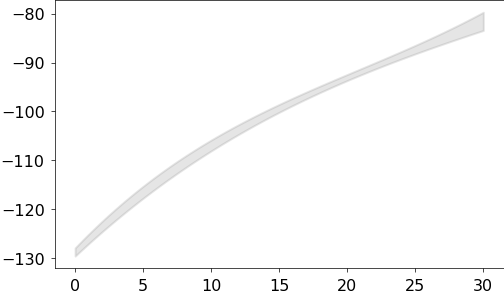

In [18]:
plt.fill_between(vac_line_x, vac_line_y1 -0.5, vac_line_y2 +0.5,
                 color='gray', alpha=0.2)

In [19]:
### import superfluid dot data
# sf_dots_x = np.genfromtxt("../data/sfdots_x.csv")
# sf_dots_y = np.genfromtxt("../data/sfdots_y.csv")
# sf_dots_Tc = np.genfromtxt("../data/sfdots_Tc.csv")

In [19]:
# put superfluid transition line data
sf_transition_x = [0.12, 0.16, 0.18, 0.20, 0.22, 0.24]
sf_transition_y = [-91.8, -85.7, -84.1, -81.4, -81.1, -81.0]

In [20]:
def bottom_line(x_find):
    for i, x in enumerate(vac_line_x):
        if x >= x_find:
            return vac_line_y2[i] +0.5

In [21]:
# draw superfluid regime
magic_x = np.linspace(5,10,20)
magic_yu = np.sqrt(magic_x)-103.8
magic_yd = np.sqrt(magic_x)-105

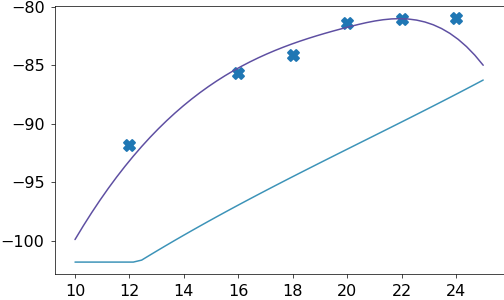

In [22]:
# draw superfluid regime
from scipy.interpolate import UnivariateSpline
target_x = [val*100 for val in sf_transition_x]
target_x.insert(0, 10)
target_x.append(25)
target_y = list(sf_transition_y)
target_y.insert(0, magic_yu[-1])
target_y.append(bottom_line(25))
plt.scatter(np.array(sf_transition_x)*100, sf_transition_y, 
            s = 30, marker='X', color='tab:blue', )

new_x = np.linspace(10,25,50)
sfbulk = UnivariateSpline(target_x, target_y,)
plt.plot(new_x, sfbulk(new_x))
sfbulk_low = [max(bottom_line(k),magic_yd[-1]) for k in new_x[:]]
# sfbulk_low.insert(0, sfbulk(10)-1)
plt.plot(new_x[:], sfbulk_low)

In [23]:
sf_transition_x

[0.12, 0.16, 0.18, 0.2, 0.22, 0.24]

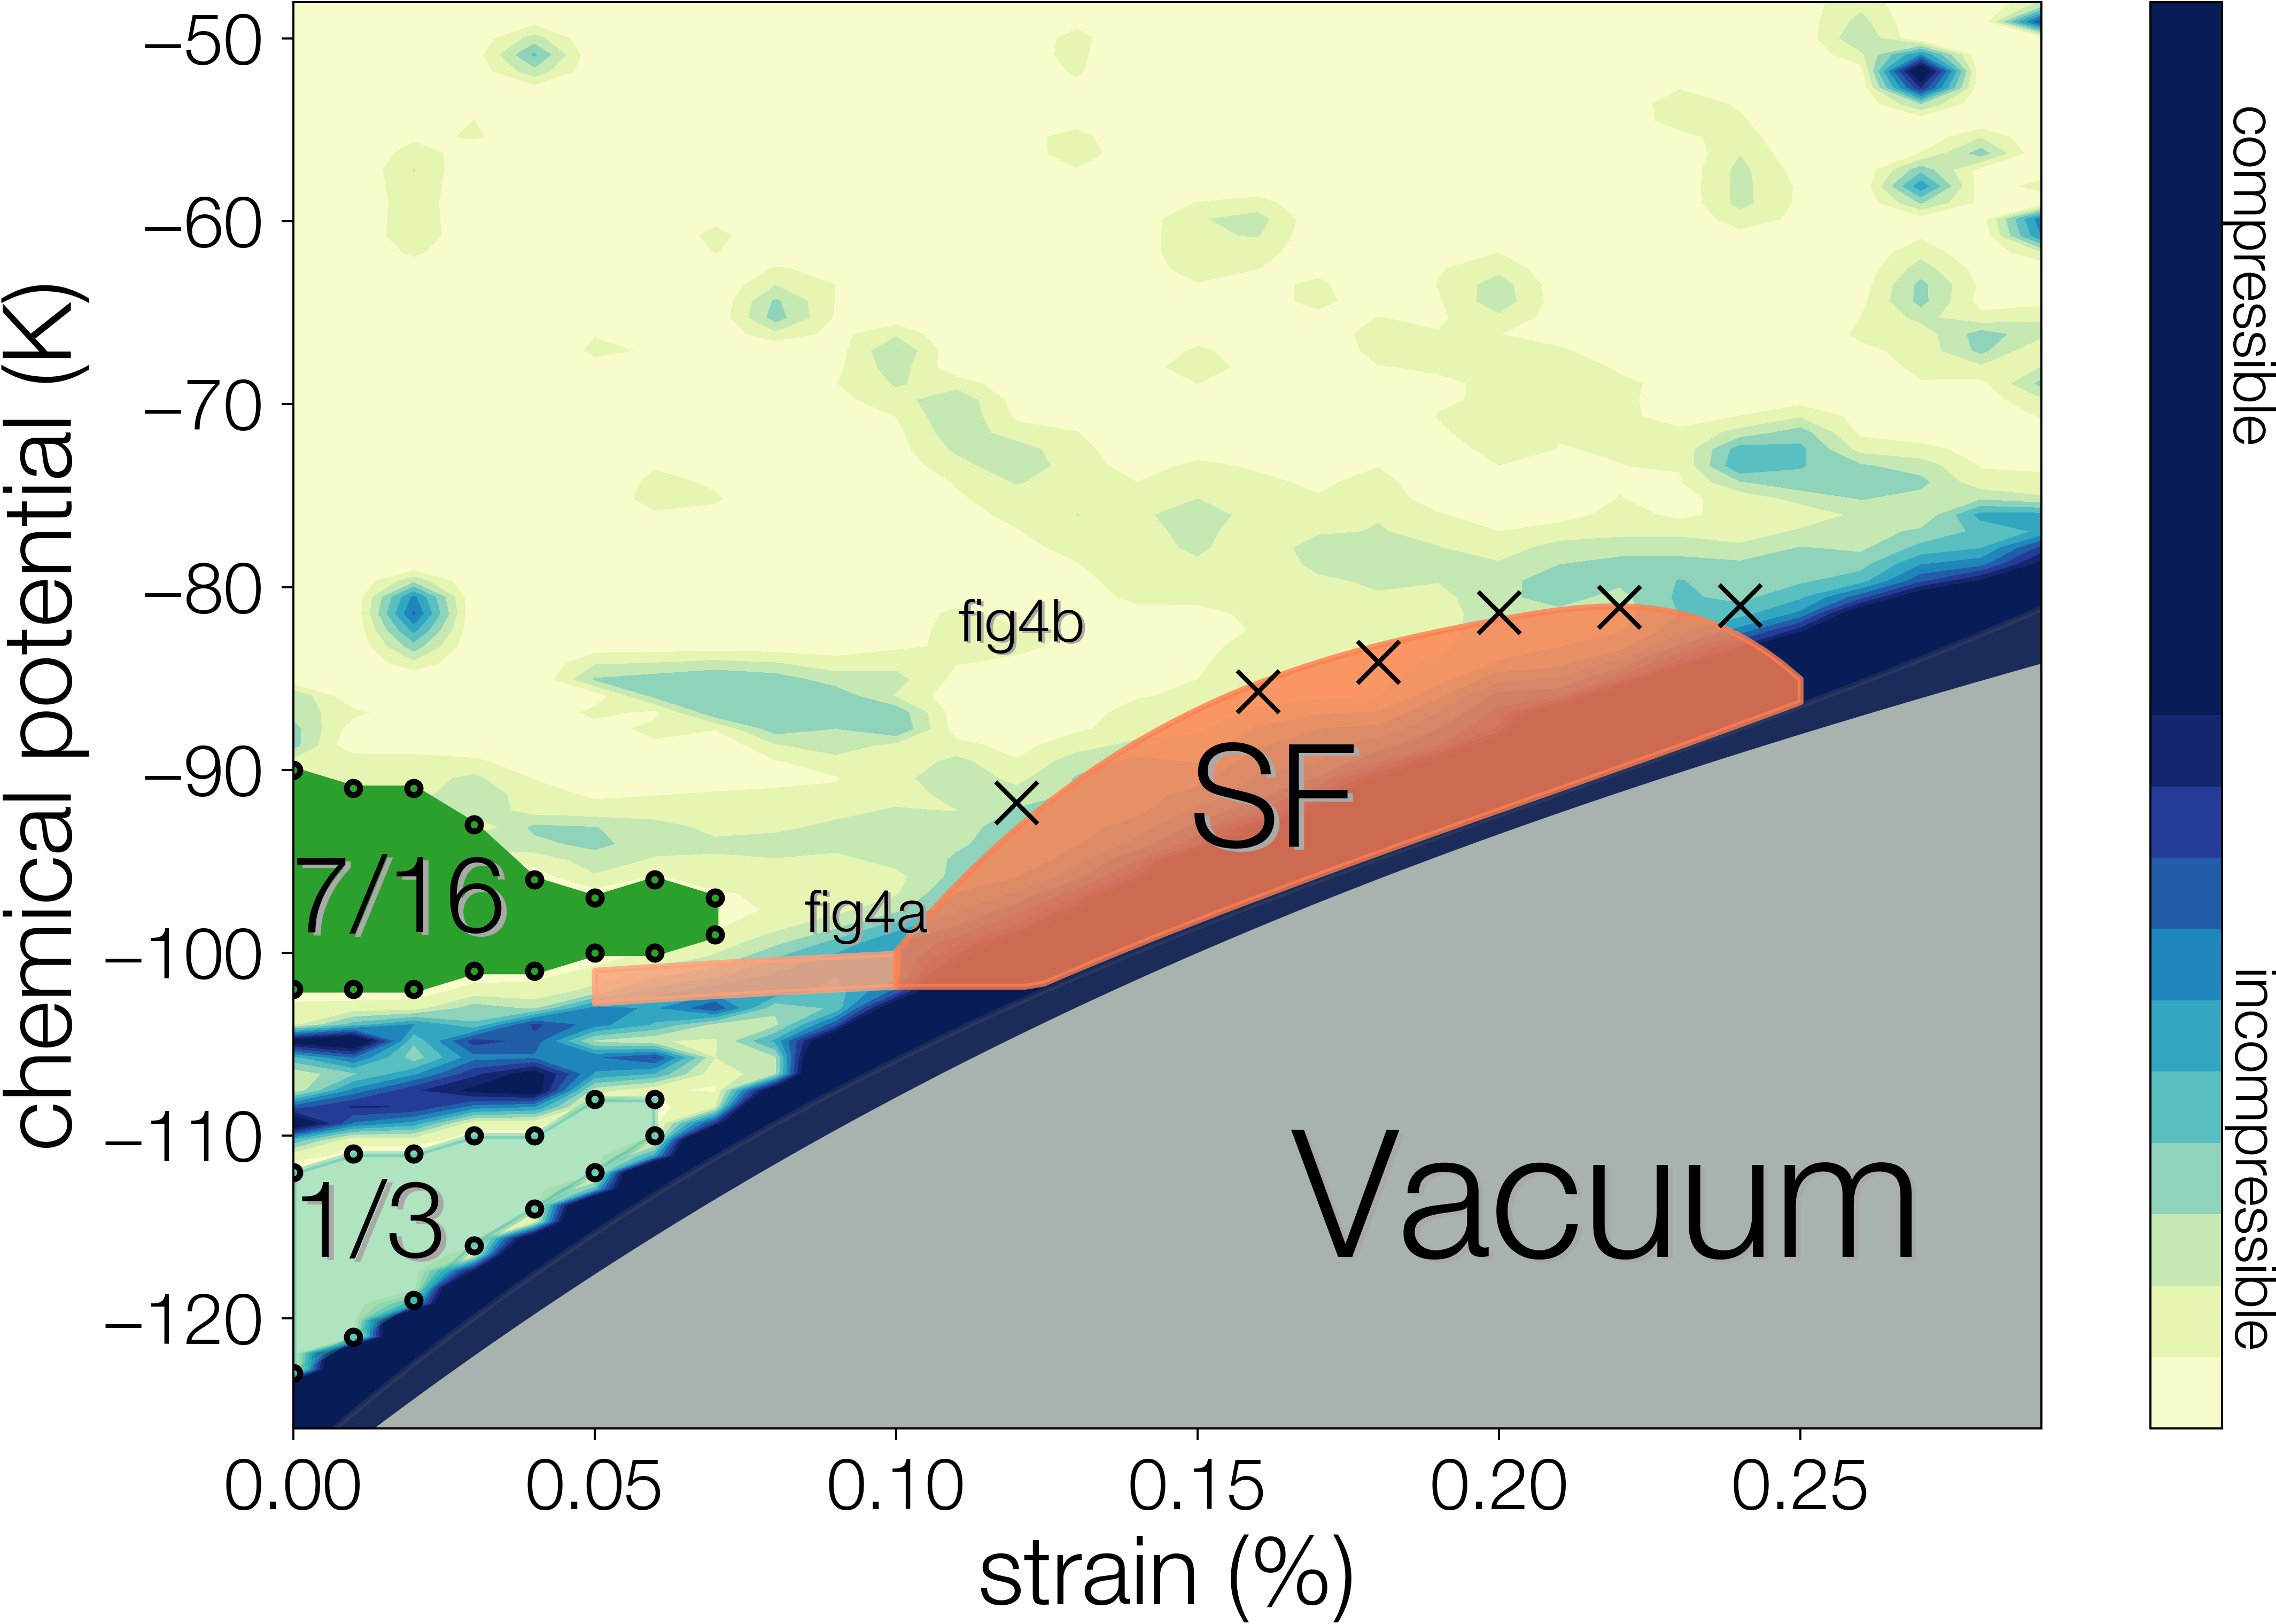

In [24]:
# Phase diagram
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    ppfig, ax = plt.subplots(figsize = [6,4],dpi=400)
    dgutils.fonts.set_custom_font(font_path)
    pphase = ax.contourf(strain_lst*0.01, murange, np.transpose(data_cprb_intp),20, vmin = 0, vmax = 0.5, cmap="YlGnBu")
    cbar = ppfig.colorbar(pphase)
    cbar.set_ticks([])
    # Vacuum line
    vac_line_plotx = vac_line_x*0.01
    plt.fill_between(vac_line_plotx, vac_line_y1 -0.5, vac_line_y2 +0.5,
                     color='dimgrey', alpha=0.2)
    # Vacuum area
    plt.fill_between(vac_line_plotx, vac_line_y1 -0.5, [-130,]*(len(vac_line_x)),
                     color='#a8b2af', )
    # One third
    one_third_x = [idx for idx in range(len(one_third_bound))]
    one_third_x = np.array(one_third_x)*0.01
    plt.fill_between(one_third_x, 
                     np.array(one_third_bound)[:,0], 
                     np.array(one_third_bound)[:,1],
                     color='#22b2aa55', )
    plt.scatter(one_third_x, np.array(one_third_bound)[:,0], s = 20,
                     marker='.', color='#22b2aa55', edgecolors= 'k')
    plt.scatter(one_third_x, np.array(one_third_bound)[:,1], s = 20,
                     marker='.', color='#22b2aa55', edgecolors= 'k')

    # seven_sixteenth
    seven_sixteenth_x = [idx for idx in range(len(seven_bound))]
    seven_sixteenth_x = np.array(seven_sixteenth_x)*0.01
    plt.fill_between(seven_sixteenth_x, 
                     np.array(seven_bound)[:,0], 
                     np.array(seven_bound)[:,1],
                     color='tab:green', )
    plt.scatter(seven_sixteenth_x, np.array(seven_bound)[:,0], s = 20,
                     marker='.', color='tab:green', edgecolors= 'k')
    plt.scatter(seven_sixteenth_x, np.array(seven_bound)[:,1], s = 20,
                     marker='.', color='tab:green', edgecolors= 'k')

    # Magic SF
    plt.fill_between(magic_x*0.01 , magic_yu+0.6, magic_yd,
                     color='lightsalmon', alpha = 0.8)
    # Line
    plt.plot([3, 14],[-101, -101], color='k', linestyle = '--', lw = 1.5)
    plt.vlines(12, -103, -84, colors='k', linestyles='-.', lw = 1.5)
    
    # Bulk SF
    plt.fill_between(new_x*0.01 , sfbulk(new_x), sfbulk_low,
                     color='coral', alpha=0.8)
    plt.scatter(np.array(sf_transition_x), sf_transition_y, 
                s = 50, marker='x', color='k', )
    
    # setting
    plt.xlim(0, 0.29)
    plt.ylim(-126, -50+2)
    plt.xlabel('strain (%)', fontsize=16)
    plt.ylabel('chemical potential (K)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # text
    ppfig.text(0.882,0.72,'compressible',fontsize = 10, rotation = -90)
    ppfig.text(0.882,0.19,'incompressible',fontsize = 10, rotation = -90)
    ppfig.text(0.522,0.238,'Vacuum',color='darkgrey', fontsize = 30)
    ppfig.text(0.52,0.24,'Vacuum',color='k', fontsize = 30)
    ppfig.text(0.482,0.478,'SF',color='darkgrey', fontsize = 24)
    ppfig.text(0.48,0.48,'SF',color='k', fontsize = 24)
    ppfig.text(0.132,0.238,'1/3',color='darkgrey', fontsize = 18)
    ppfig.text(0.13,0.24,'1/3',color='k', fontsize = 18)
    ppfig.text(0.132,0.428,'7/16',color='darkgrey', fontsize = 18)
    ppfig.text(0.13,0.43,'7/16',color='k', fontsize = 18)
    ppfig.text(0.331,0.429,'fig4a',color='darkgrey', fontsize = 10)
    ppfig.text(0.33,0.43,'fig4a',color='k', fontsize = 10)
    ppfig.text(0.391,0.599,'fig4b',color='darkgrey', fontsize = 10)
    ppfig.text(0.39,0.60,'fig4b',color='k', fontsize = 10)
    plt.tight_layout()
    plt.show()
    
    # save?
#     ppfig.savefig('../figures/phase_diagram.png', bbox_inches='tight', dpi=600, pad_inches=0.1,)

# 2D density frame generator

In [25]:
def den_maker_from_raw(subset):
    if len(subset) != 1:
        print("the subset has more than one data")
        return None
    else:

        mulst = np.array(subset['mu'])

        file = subset.iloc[0]['filedic']['planeavedensity'] #file location
        with open(file,'r') as lines:
            header = lines.readline()
        ngridsep = int(header.split(' ')[-1][:-1])
        densityData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
        rho = densityData.reshape([ngridsep,ngridsep]) #reshape to 2d
        box = [float(header.split(' ')[4])*ngridsep, float(header.split(' ')[7])*ngridsep]
        dens = round(float(one_set['n']/one_set['totN']), 4)

        return mulst, rho, box, ngridsep, dens

In [26]:
def den_maker_single(file):
    with open(file,'r') as lines:
        header = lines.readline()
        ngridsep = int(header.split(' ')[-1][:-1])
        densityData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
        rho = densityData.reshape([ngridsep,ngridsep]) #reshape to 2d
        box = [float(header.split(' ')[4])*ngridsep, float(header.split(' ')[7])*ngridsep]

        return rho, box, ngridsep
# Export data
# dbase.to_csv('../data/T1comm_data.csv',index=False)

In [31]:
# from graphenetools import gt
# import matplotlib.patheffects as path_effects
# path_eff = [path_effects.withSimplePatchShadow(offset=(0.06, -0.06), shadow_rgbFace='k', alpha=1.0)]
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Helvetica Neue


1.27


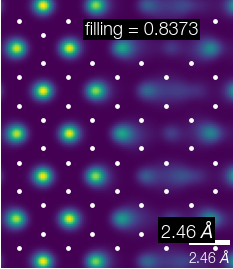

In [30]:
## strain : s, chemical potential : muval
## plot from raw data

# s = 27
# muval = -52
# subset = dbase[dbase['strain'] == s/100]
# scale = s/100+1
# print(scale)
# one_set = subset[ (subset['mu'] == muval) ]
# mulst, rho, box, ngrid, dens = den_maker_from_raw(one_set)


# plt.style.reload_library()
# with plt.style.context(plot_style['sans']):
#     snap_fig, ax = plt.subplots()
#     dgutils.fonts.set_custom_font(font_path)

#     inset = ax.imshow(rho.T*10, extent=[-0.5*box[0],0.5*box[0],-0.5*box[1],0.5*box[1]])
#     plt.axis('off')
#     snap_fig.text(0.55,0.81,'filling = '+f'{dens}', 
#                   c='white', fontsize = 9,
#     #               path_effects=path_eff,?
#                   bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
#                  )
#     c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,[x/(scale) for x in box]))
#     c_positions *= scale
#     ax.scatter(c_positions[:,0],c_positions[:,1], s=2, c='w')
#     fixbox = [14.7570726, 17.03999975]
#     ax.set_xlim(-0.5*fixbox[0],0.5*fixbox[0])
#     ax.set_ylim(-0.5*fixbox[1],0.5*fixbox[1])
#     snap_fig.text(0.64,0.151, '2.46 '+ r'${\rm \AA}$', 
#                   c='white', fontsize = 9,
#     #               path_effects=path_eff,
#                   bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
#                  ) #family= 'sans-serif',? r'2.46'+ r'$\mathrm{\AA}$'
#     scalebar = AnchoredSizeBar(ax.transData,
#                                2.46, '2.46 '+ r'${\rm \AA}$', 'lower right', 
#                                pad=0.1,
#                                color='white',
#                                frameon=False,
#                                size_vertical=0.2,
#                               )
#     # scalebar.set_path_effects(path_eff)
#     ax.add_artist(scalebar)

# # snap_fig.savefig('./Allfigures/snap_30-52_enh2.png')

In [28]:
rhos = []
boxs = []


### from repository data
denses = [0.3335, 0.4375, 0.5564, 0.6829, 0.8373, 0.9478]
scales = [1.0, 1.0, 1.08, 1.22, 1.27, 1.30]
for i in range(6):
    _file_name = '../data/planeden'+f'{i}'+'.dat'
    rho, box, _ = den_maker_single(_file_name)
    print(_file_name)
    rhos.append(rho)
    boxs.append(box)

set_of_smu = [
    [0,-115],
    [0,-94],
    [8,-65],
    [22,-57],
    [27,-52], 
    [30,-52], 
]
### from raw data
# scales = []
# denses = []
# for i, pair in enumerate(set_of_smu):
#     s = pair[0]
#     muval = pair[1]
#     subset = dbase[dbase['strain'] == s/100]
#     scale = s/100+1
#     one_set = subset[ (subset['mu'] == muval) ]
#     _, rho, box, _, dens = den_maker_from_raw(one_set)
#     ref_file = one_set.iloc[0]['filedic']['planeavedensity']
#     print(ref_file)
#     !cp {ref_file} ../data/planeden{i}.dat
#     rhos.append(rho)
#     boxs.append(box)
#     denses.append(dens)
#     scales.append(pair[0]/100+1)

../data/planeden0.dat
../data/planeden1.dat
../data/planeden2.dat
../data/planeden3.dat
../data/planeden4.dat
../data/planeden5.dat


In [29]:
ref_x = np.array(set_of_smu)[:,0]
ref_y = np.array(set_of_smu)[:,1]

In [30]:
sf_rho, sf_box, _ = den_maker_single('../data/planeden_super.dat')
sf_ref_x, sf_ref_y = 15, -93
sf_dens = 0.4196

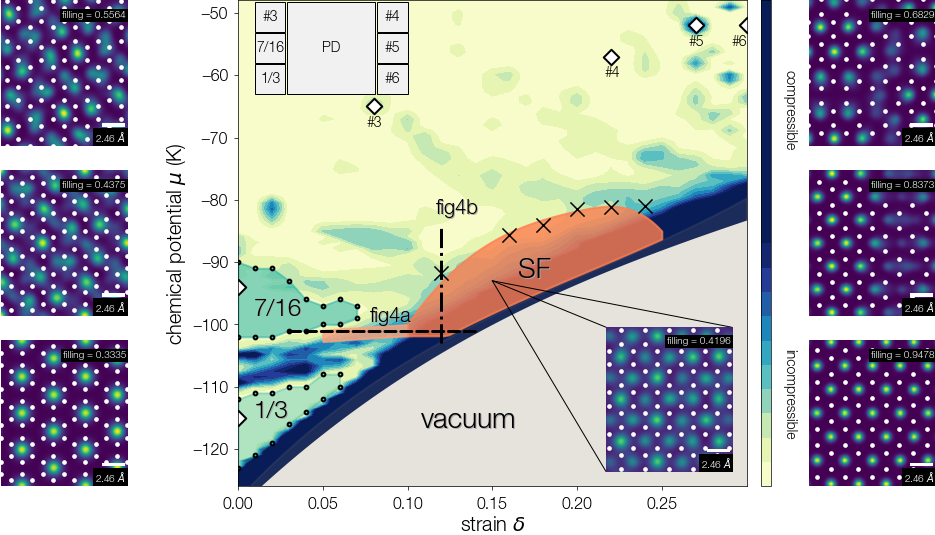

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mosaic = """
cAAAd
bAAAe
aAAAf
"""
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    pd_fig = plt.figure(constrained_layout=True ,figsize = (3.4646*2, 2.14122**1.75))
    dgutils.fonts.set_custom_font(font_path)
    ax_dict = pd_fig.subplot_mosaic(mosaic)
    
    panels = ["a","b","c","d","e","f"]
    for i in range(6):
        axi = ax_dict[panels[i]]
        axi.imshow(rhos[i].T*10, extent=[-0.5*boxs[i][0],0.5*boxs[i][0],-0.5*boxs[i][1],0.5*boxs[i][1]])
        axi.axis('off')

        axi.text(0.74,0.88,'filling = '+f'{denses[i]}', 
                      c='white', fontsize = 5, transform=axi.transAxes,
                      bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
                     )
        c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,[x/(scales[i]) for x in boxs[i]]))
        c_positions *= scales[i]
        axi.scatter(c_positions[:,0],c_positions[:,1], s=1.8, c='w')
        fixb = [14.7570726, 17.03999975]
        axi.set_xlim(-0.5*fixb[0],0.5*fixb[0])
        axi.set_ylim(-0.5*fixb[1],0.5*fixb[1])
        axi.text(0.87,0.029, '2.46 '+ r'${\rm \AA}$', 
                      c='white', fontsize = 5, transform=axi.transAxes,
                      bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
                     ) #family= 'sans-serif',?
        scalebar = AnchoredSizeBar(axi.transData,
                                   2.46, '', 'lower right', 
                                   pad=0.1,
                                   color='white',
                                   frameon=False,
                                   size_vertical=0.2,
                                  )
        axi.add_artist(scalebar)
        
    ##############################################################
    ax = ax_dict["A"]
    pphase = ax.contourf(strain_lst*0.01, murange, np.transpose(data_cprb_intp),20, vmin = 0, vmax = 0.5, cmap="YlGnBu")
    dgutils.fonts.set_custom_font(font_path)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar = pd_fig.colorbar(pphase, cax=cax, orientation='vertical')
    cbar.set_ticks([])
    # Vacuum line
    vac_line_plotx = vac_line_x*0.01
    ax.fill_between(vac_line_plotx, vac_line_y1 -0.5, vac_line_y2 +0.5,
                     color='dimgrey', alpha=0.2)
    # Vacuum area
    ax.fill_between(vac_line_plotx, vac_line_y1 -0.5, [-130,]*(len(vac_line_x)),
                     color='#e6e2dc', )
    # One third
    one_third_x = [idx for idx in range(len(one_third_bound))]
    one_third_x = np.array(one_third_x)*0.01
    ax.fill_between(one_third_x, 
                     np.array(one_third_bound)[:,0], 
                     np.array(one_third_bound)[:,1],
                     color='#22b2aa55', )
    ax.scatter(one_third_x, np.array(one_third_bound)[:,0], s = 14,
                     marker='.', color='#22b2aa55', edgecolors= 'k')
    ax.scatter(one_third_x, np.array(one_third_bound)[:,1], s = 14,
                     marker='.', color='#22b2aa55', edgecolors= 'k')

    # seven_sixteenth
    seven_sixteenth_x = [idx for idx in range(len(seven_bound))]
    seven_sixteenth_x = np.array(seven_sixteenth_x)*0.01
    ax.fill_between(seven_sixteenth_x, 
                     np.array(seven_bound)[:,0], 
                     np.array(seven_bound)[:,1],
                     color='#22b2aa88', )
    ax.scatter(seven_sixteenth_x, np.array(seven_bound)[:,0], s = 14,
                     marker='.', color='#22b2aa88', edgecolors= 'k')
    ax.scatter(seven_sixteenth_x, np.array(seven_bound)[:,1], s = 14,
                     marker='.', color='#22b2aa88', edgecolors= 'k')

    # Magic SF
    ax.fill_between(magic_x*0.01, magic_yu+0.6, magic_yd,
                     color='lightsalmon', alpha = 0.8)
    # Line
    ax.plot([0.03, 0.14],[-101, -101], color='k', linestyle = '--', lw = 1.5)
    ax.vlines(0.12, -103, -84, colors='k', linestyles='-.', lw = 1.5)
    
    # Bulk SF
    ax.fill_between(new_x*0.01 , sfbulk(new_x), sfbulk_low,
                     color='coral', alpha=0.8)
    ax.scatter(np.array(sf_transition_x), sf_transition_y, 
                s = 50, marker='x', color='k', )
    
    # setting
    ax.set_xlim(0, 0.30)
    ax.set_ylim(-126, -50+2)
    ax.set_xlabel('strain '+r'$\delta$', fontsize=10) # fontsize=20
    ax.set_ylabel('chemical potential '+r'$\mu$ (K)', fontsize=10) # fontsize=20
#     ax.tick_params(axis='x', ) # labelsize= 12
#     ax.tick_params(axis='y', )
    ax.set_xticks([0.00,0.05,0.10,0.15,0.20,0.25])
    
    # text
    pd_fig.text(0.815,0.72,'compressible', rotation = -90, ) #,fontsize = 20
    pd_fig.text(0.815,0.19,'incompressible', rotation = -90, )
    pd_fig.text(0.362,0.118,'vacuum',color='darkgrey', fontsize = 14, transform=ax.transAxes,) # fontsize = 30
    pd_fig.text(0.36,0.12,'vacuum',color='k', fontsize = 14, transform=ax.transAxes,)
    ax.text(0.552,0.428,'SF',color='darkgrey', fontsize = 14, transform=ax.transAxes,)
    ax.text(0.55,0.43,'SF',color='k', fontsize = 14, transform=ax.transAxes,)
    ax.text(0.032,0.138,'1/3',color='darkgrey', fontsize = 12, transform=ax.transAxes,) # fontsize = 24
    ax.text(0.03,0.14,'1/3',color='k', fontsize = 12, transform=ax.transAxes,)
    ax.text(0.032,0.350,'7/16',color='darkgrey', fontsize = 12, transform=ax.transAxes,)
    ax.text(0.03,0.352,'7/16',color='k', fontsize = 12, transform=ax.transAxes,)
    ax.text(0.261,0.337,'fig4a',color='darkgrey', fontsize = 10, transform=ax.transAxes,)
    ax.text(0.26,0.338,'fig4a',color='k', fontsize = 10, transform=ax.transAxes,)
    ax.text(0.391,0.559,'fig4b',color='darkgrey', fontsize = 10, transform=ax.transAxes,)
    ax.text(0.39,0.56,'fig4b',color='k', fontsize = 10, transform=ax.transAxes,)
    
    # shapes
    def gen_rect(rec_x,rec_y,lab, size=(1.8/100,4.8)):
        rec = Rectangle((rec_x,rec_y), size[0], size[1], fc='#F1F1F1',ec="black", linewidth=0.5)
        ax.add_patch(rec)
        rx, ry = rec.get_xy()
        cx = rx + rec.get_width()/2.0
        cy = ry + rec.get_height()/2.0
        ax.annotate(lab, (cx, cy), color='black', fontsize=7, ha='center', va='center')
    gen_rect(0.01,-63,'1/3')
    gen_rect(0.01,-63+5,'7/16')
    gen_rect(0.01,-63+10,r'#3')
    gen_rect(0.01+1.8*4/100,-63+10,r'#4')
    gen_rect(0.01+1.8*4/100,-63+5,r'#5')
    gen_rect(0.01+1.8*4/100,-63,r'#6')
    gen_rect(2.91/100,-63,'PD',size=((1.8*3-0.2)/100, 14.8))
    
    # reference points
    ax.scatter((ref_x)/100,ref_y, s=30, marker='D', c='white', linewidths=1, edgecolors='k')
    ax.text((ref_x[2]-0.4)/100,ref_y[2]-3.3,r'#3',color='k', )
    ax.text((ref_x[3]-0.4)/100,ref_y[3]-3.3,r'#4',color='k', )
    ax.text((ref_x[4]-0.4)/100,ref_y[4]-3.3,r'#5',color='k', )
    ax.text((ref_x[5]-0.9)/100,ref_y[5]-3.3,r'#6',color='k', )
    
    # superfluid inset
    ax.plot([0.15, 0.217],[sf_ref_y, -100.45], color='k', linestyle = '-', lw = 0.5)
    ax.plot([0.15, 0.291],[sf_ref_y, -100.45], color='k', linestyle = '-', lw = 0.5)
    ax.plot([0.15, 0.217],[sf_ref_y, -123.6], color='k', linestyle = '-', lw = 0.5)
    
    sf_axins = inset_axes(ax, width="25%", height="30%", loc=4, borderpad=1)
    sf_axins.imshow(sf_rho.T, extent=[-0.5*sf_box[0],0.5*sf_box[0],-0.5*sf_box[1],0.5*sf_box[1]])
    sf_axins.axis('off')

    sf_axins.text(0.74,0.88,'filling = '+f'{sf_dens}', 
                  c='white', fontsize = 5, transform=sf_axins.transAxes,
                  bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
                 )
    c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,[x/(1.15) for x in sf_box]))
    c_positions *= 1.15
    sf_axins.scatter(c_positions[:,0],c_positions[:,1], s=1.8, c='w')

    sf_axins.set_xlim(-0.5*fixb[0],0.5*fixb[0])
    sf_axins.set_ylim(-0.5*fixb[1],0.5*fixb[1])
    sf_axins.text(0.87,0.029, '2.46 '+ r'${\rm \AA}$', 
                  c='white', fontsize = 5, transform=sf_axins.transAxes,
                  bbox={'facecolor':'black','alpha':1,'edgecolor':'none','pad':1},ha='center'
                 ) #family= 'sans-serif',?
    scalebar = AnchoredSizeBar(sf_axins.transData,
                               2.46, '', 'lower right', 
                               pad=0.1,
                               color='white',
                               frameon=False,
                               size_vertical=0.2,
                              )
    sf_axins.add_artist(scalebar)
    

#    pd_fig.savefig('../figures/fig3.pdf')

# Continue?

In [53]:
target = fulldbase[(fulldbase['estsize']<3000)&(fulldbase['strain']<0.31)&(fulldbase['strain']>=0.11)]
print(len(target))
date = 'May25'
gensub.continue_from(target, 'pimc_t1comm_cont', date, suffix = 1)

608
writing at  /home/sang/UVM/He4HighT/pimc_t1comm_cont_May25_1.sh
The number of simulations in this dataframe : 608
Your file is ready.
